# Error propagation and confidence intervals for correlated data points 

You have the data file "data_cov.dat" which contains 10 pairs of measurements $(a_i, b_i)$. You consider reporting the mean and standard deviation on $a$ and $b$. Is this information sufficient to calculate a 99% confidence interval on $\bar{c} = \bar{a} + \bar{b}$? Explain why this is not sufficient and show it through a numerical experiment.   

Bonus: Calculate a 99\% CI on $\bar{c}$. 

Tip: Instead of calculating the sample covariance manually, you can use `np.cov(a, b, ddof=1)`. 

Guidline for solving this exercise: 

- 1) Visualise the pairs of data points $(a_i, b_i)$
- 2) Evaluate the covariance matrix of your sample and pearson correlation coefficient.
- 3) Derive a p-value for your observed correlation coefficient. Is the correlation between a and b meaningful?
- 4) Compare the variance on $c = a+b$ to the variance you would derive from the error propagation formula. Compare the results if you include of drop the covariance between a and b in the error propagation formula. 

## About correlation coefficients

Given two length-$N$ samples of data $\{x_i\}$ and $\{y_i\}$, Pearson's correlation coefficient is defined as

$$ r = \frac{\sum_{i=1}^N (x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}^N (x_i-\bar{x})^2}\sqrt{\sum_{i=1}^N (y_i-\bar{y})^2}} $$

where $-1\leq r\leq 1$, and $r=0$ for uncorrelated variables.

If the pairs $(x_i,y_i)$ are drawn from uncorrelated univariate Gaussian distributions, then the distribution of $r$ follows a Student's $t$ distribution with $k=N-2$ degrees of freedom and $t = r\sqrt{(N-2)/(1-r^2)}$ (so this is the normalised RV $r$ built based on t that follows a student ; this also means that the $stde(r) = \sqrt{\frac{1-r^2}{N-2}}$).

Because of this, a measured $r$ can be interpreted in terms of the significance with which we can reject the variables being correlated. 
E.g., for $N=10$ you can estiamte probability that a value of $r$ arises just by chance noise fluctuations using a Student $t$ distribution. 

### About p-value 

The p-value is the probability for getting a value at least as large as the one observed. So a small p-value (conventionally smaller than 0.05) is used as an indication that the obtained value is not a statistical fluke. One may however not abuse of it / puts too much trust in it (but it is sometimes the only objective way we have to quantify a "visual" statement). 

HERE, we are not testing if there is a strong correlation, but testing that the coefficient we find can happen due to statistical fluctuations. A large positive $r$ means strong positive correlation and large negative means anti-correlation. We care about extreme values in both directions so: 
$p = 2 \times P(T \geq |t|))$ (where $T$ is the t-distribution with $n-2$ dof. 

HERE, a low p-value does not mean the correlation is weak, it means:  If there were truly no correlation, the chance of observing such an extreme r (positive or negative) is very small.
So, a low p-value gives us confidence that the observed correlation (positive or negative) is real, not random noise.

### More about correlation coefficients

The Pearson's coefficient can be calculated in python using `numpy.corrcoef()`.  

Note that there are two problems with Pearson's coefficient:
- It does not incorporate measurement uncertainties on the data.
- It is highly susceptible to outliers.

Alternative coefficients have been introduced, such as the Spearman's-r coefficient (less sensible to outliers but biased) and the Kendall's-$\tau$ coeffcient. 

See **Chapter 3** of of the book <a class="anchor" id="book"></a> *Statistics, data mining and Machine learning in astronomy* by Z. Ivezic et al. in Princeton Series in Modern Astronomy for a more exhaustive discussion of correlation coefficients (and alternatives to Pearson's $r$ correlation coefficient). 

Why $n-1$ as Bessel's correction for calculating the covariance $\sigma_{ab}$ (i.e. `np.cov(a, b, ddof=1)`) ? See https://stats.stackexchange.com/questions/142456/why-shouldnt-the-denominator-of-the-covariance-estimator-be-n-2-rather-than-n-1/142472#142472 . 

In [2]:
import numpy as np
import scipy.stats 
from matplotlib import pyplot as plt

Text(0, 0.5, 'b')

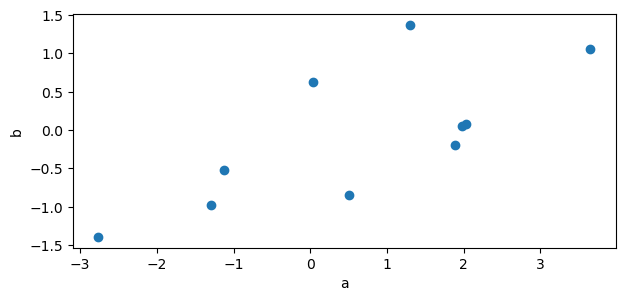

In [14]:
# Visualising the data
data_sample = np.loadtxt('data_cov.dat')    # load the data 
a, b = data_sample[:,0], data_sample[:,1]      # save a, b columns into variables for legibility 

# Create an axis object to visualise the data points 
# ADD HERE A row to visualise the data 
f, ax = plt.subplots(figsize=(7,7))
ax.scatter(a, b)
ax.set_aspect('equal')
ax.set_xlabel('a')
ax.set_ylabel('b')

In [15]:
# calculate the covariance matrix to quantify the visual evidence for a correlation
cov_mtrx = np.cov(a, b, ddof=1)
cov_mtrx

array([[3.73700531, 1.25525937],
       [1.25525937, 0.80895795]])

In [8]:
# Calculate a correlation coefficient and its uncertainty (as a complement to assess the covariance)
r_direct = cov_mtrx[0, 1] / (np.sqrt(cov_mtrx[0, 0]) * np.sqrt(cov_mtrx[1, 1]))  # using explicit formula
pearson_cor = np.corrcoef(a, b)
pearson_r = pearson_cor[0,1]  # the pearson coef. between a and b is along the non diag. element
print('pearson correlation', pearson_cor)
print('pearson r', pearson_r )
print('Direct calculation of pearson %.3f' %(cov_mtrx[0, 1] / (np.sqrt(cov_mtrx[0, 0]) * np.sqrt(cov_mtrx[1, 1]))))

pearson correlation [[1.         0.72195253]
 [0.72195253 1.        ]]
pearson r 0.7219525262865987
Direct calculation of pearson 0.722


In [9]:
# What is the error on the correlation coefficient? 
Npts = len(a)
stde_r = np.sqrt((1-pearson_r**2) / (Npts-2) )
print('Pearson correlation coef. %.3f (stde(r) = %.3f)' %(pearson_r, stde_r))

Pearson correlation coef. 0.722 (stde(r) = 0.245)


In [10]:
# Calculate the p value to see if our value of r could have been as large just from statistical fluctuations

# Let's calculate the p value to see if our value of r could have been as large 
# distribution of the pearson correlation coef. 
dist_pearson = scipy.stats.t(Npts - 2)   # t(N-2) 
t_test =  pearson_r * np.sqrt( (Npts-2) / (1-pearson_r**2) ) 

p_val = 1 - dist_pearson.cdf(t_test)
print('p-value (one-tailed) of Pearson r = %.3f'%p_val) 
# we may prefer a 2-tailed p-value ; a r = -0.722 would be an anti-correlation
# We can multiply the one-tailed by 2 because of the symmetry of the distribution
print('p-value (two-tailed) of Pearson r = %.3f'% (2. * p_val))   

p-value (one-tailed) of Pearson r = 0.009
p-value (two-tailed) of Pearson r = 0.018


In [17]:
# We can calculate the standard deviation and the sqrt(covariance) 
# based on the elements of the cov matrix
# Diagonal elements = variance ; non diagonal elements = covariance
std_a = np.sqrt(cov_mtrx[0, 0])  
std_b = np.sqrt(cov_mtrx[1, 1])
std_ab = cov_mtrx[0,1]
print('<a> = %.2f ; std_a = %.2f'%(a.mean(), std_a))
print('<b> = %.2f ; std_b = %.2f'%(b.mean(), std_b))
print('std_ab = %.2f'%std_ab)

<a> = 0.62 ; std_a = 1.93
<b> = -0.08 ; std_b = 0.90
std_ab = 1.26


Let's now verify that giving the std is not enough to calculate a CI on c. 
Based on the error propagation formula, we know that the variance on c transofrms as: 

$$
\sigma^2_c =  \sigma^2_a + \sigma^2_b + 2 * \sigma_{ab}
$$

Providing only $\bar{a}$, $\bar{b}$ , $\sigma^2_a$, $\sigma^2_b$ means that we would drop the covariance ...    

Let's compare the variance on c to the variance derived from the error propagation formula without and with the covariance. 

In [19]:
# True variance on c
c = a + b 
var_c = np.var(c, ddof=1)

# Variance on c from error propagation ignoring the covariance 
var_c_no_cov = cov_mtrx[0, 0] + cov_mtrx[1, 1]
var_c_w_cov = cov_mtrx[0, 0] + cov_mtrx[1, 1] + 2 * cov_mtrx[1, 0]

print('True variance on c = %.3f '%var_c)
print('Variance on c from a, b ignoring the covariance: %.3f ' %var_c_no_cov)
print('Variance on c from a, b accounting for the covariance: %.3f ' %var_c_w_cov)

True variance on c = 7.056 
Variance on c from a, b ignoring the covariance: 4.546 
Variance on c from a, b accounting for the covariance: 7.056 


### Confidence interval CI on $\bar c$ 

In [20]:
# for this we need to calculate the standard error on \bar{c} 
# and use t-test because we have an estimate of the sample variance (std)
c_mean = c.mean()
alpha = 0.01   # 99% CI
stde_c = c.std(ddof=1) / np.sqrt(Npts)
t_dist = scipy.stats.t(Npts-1)
t1, t2 = t_dist.ppf(alpha/2.), t_dist.ppf(1-alpha/2.)   # it is centered on a mean 0
at1, at2 = c_mean + t1 * stde_c, c_mean + t2 * stde_c 
print("%.2f percents CI around <c> = %.2f is [%.2f,%.2f]" %((1-alpha)*100., c_mean, at1, at2) )

99.00 percents CI around <c> = 0.54 is [-2.19,3.27]


NB: You can also do the pearson correlation analysis using `scipy.stats.pearsonr()`

In [11]:
# Now, we can do all this at once with 
scpy_pearson, scpy_p_val = scipy.stats.pearsonr(a, b)
print('Scipy calculation')
print('Pearson correlation coef. %.3f , and p-val = %.3f' %(scpy_pearson, scpy_p_val))
print('Scipy returns 2-tailed p-value which is TWICE the one-tailed p-val')

Scipy calculation
Pearson correlation coef. 0.722 , and p-val = 0.018
Scipy returns 2-tailed p-value which is TWICE the one-tailed p-val
